In [141]:
# IMPORT LIBRARIES

import torch
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2025)

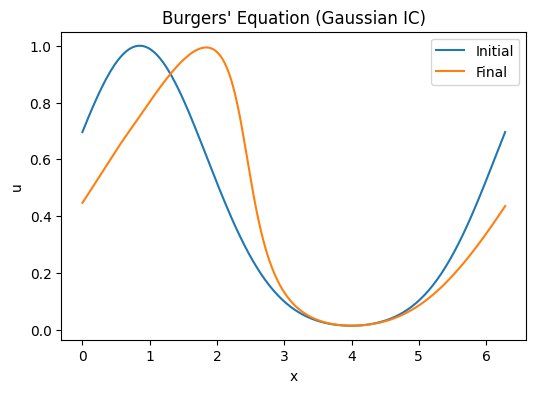

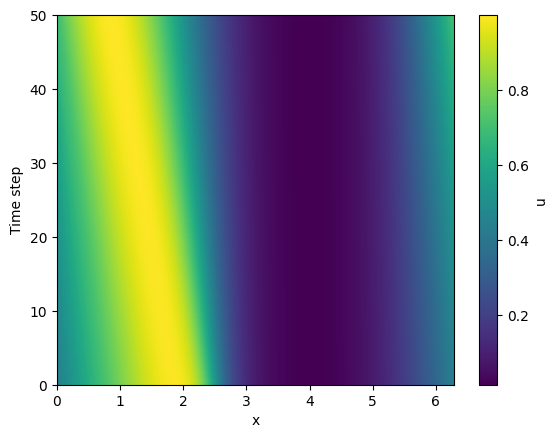

In [142]:
import numpy as np
import matplotlib.pyplot as plt

def burgers_solver(nx=101, nt=200, L=2*np.pi, T=1.0, nu=0.01, init_cond='sine'):
    """
    Solve 1D viscous Burgers' equation using finite differences.

    Parameters:
        nx   : number of spatial grid points
        nt   : number of time steps
        L    : domain length
        T    : final time
        nu   : viscosity
        init_cond : type of initial condition ("sine", "gaussian", "square")
    """
    x = np.linspace(0, L, nx)
    
    if init_cond == "sine":
        freq = np.random.randint(low=1, high=5)
        phi = L*np.random.random_sample(1)*2
        print(freq, phi)
        u0 = lambda x: np.sin(freq * x + phi) 
    elif init_cond == "gaussian":
        # make periodic Gaussian by summing images
        x0 = np.random.random(1) * L
        sigma = 1  # width of Gaussian
        def u0(x):
            u = np.zeros_like(x)
            # sum over a few images for periodicity
            for k in [-1,0,1]:
                u += np.exp(-((x - x0 + k*L)**2)/(2*sigma**2))
            return u
    elif init_cond == "square":
        u0 = lambda x: np.where((x > L/3) & (x < 2*L/3), 1.0, 0.0)
    else:
        raise ValueError("Unknown initial condition")

    dx = L / (nx - 1)
    dt = T / nt

    # Grid
    t = np.linspace(0, T, nt + 1)
    u = u0(x).copy()
    U = [u.copy()]

    # Time stepping
    for n in range(nt):
        un = u.copy()

        # Convection (upwind scheme)
        convection = un * (un - np.roll(un, 1)) / dx

        # Diffusion (central scheme)
        diffusion = nu * (np.roll(un, -1) - 2*un + np.roll(un, 1)) / dx**2

        # Update
        u = un - dt * convection + dt * diffusion
        U.append(u)

    return t, x, u, np.array(U)


if __name__ == "__main__":
    t, x, u, U = burgers_solver(nu=1e-4, nx=200, nt=50, init_cond='gaussian')
    plt.figure(figsize=(6,4))
    plt.plot(x, U[0], label="Initial")
    plt.plot(x, u, label="Final")
    plt.title("Burgers' Equation (Gaussian IC)")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend()
    plt.figure()
    plt.imshow(U, aspect='auto', extent=[0, 2*np.pi, 0, 50])
    plt.xlabel("x")
    plt.ylabel("Time step")
    plt.colorbar(label="u")
    plt.show()


(401, 200)


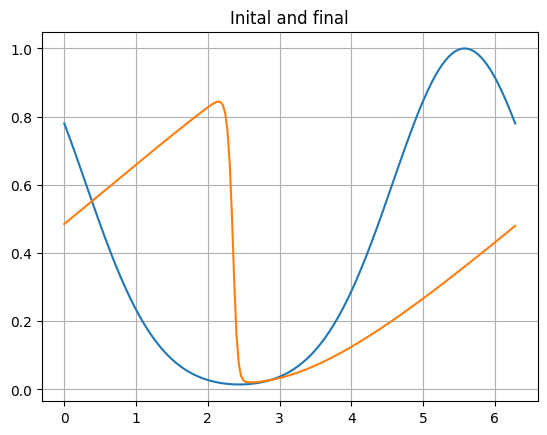

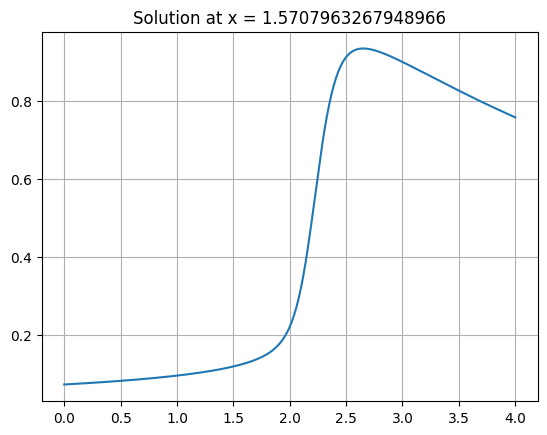

In [143]:
L = 2*np.pi
T = 4.0
nx = 200
nt = 400 
nu = 0.01
def gaussian(x, mu = L/2, sigma = 1):
    sigma = np.random.random(1)
    mu = np.random.random_sample(1)*L/2
    return 1/np.sqrt(2*np.pi * sigma) * np.exp(- ((x-mu)/sigma)**2)

def sinusoidal(x):
    return 0.3*np.sin(np.random.randint(low = 1, high = 6) * x + L*np.random.random_sample(1)) 
t, x, u, U = burgers_solver(nu = nu, nx = nx, nt = nt, L = L, init_cond =  'gaussian', T = T)
print(np.shape(U))
idx =50

plt.title(f'Inital and final')
plt.plot(x, U[0,:], label = f'inital')
plt.plot(x, U[-1,:], label = f'final')
plt.grid(True)
plt.figure()
plt.title(f'Solution at x = {idx*L/nx}')
plt.plot(t, U[:,idx])
plt.grid(True)


In [144]:
import warnings
def safe_burgers_solver(max_retries=10, **kwargs):
    """
    Wrapper to handle overflow errors and restart with smaller dt.
    
    Parameters
    ----------
    max_retries : int
        Maximum number of attempts with smaller dt before giving up.
    kwargs : dict
        Arguments passed to burgers_solver.
    """
    retries = 0
    while retries < max_retries:
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("error", category=RuntimeWarning)  # turn warnings into errors
                return burgers_solver(**kwargs)
        except RuntimeWarning:
            print(f"Overflow detected! Reducing time step (attempt {retries+1}/{max_retries})...")
            # Reduce dt by doubling nt
            kwargs["nt"] *=  2
            retries += 1
    
    raise RuntimeError("Solver failed after maximum retries with smaller dt.")

In [145]:
from scipy.interpolate import interp1d

# DATA GENERATION
nu_range = [1e-4, 1e-2]
L = 2*np.pi
T = 4.0
nx = 100
nt = 100 
nu = 0.1
t = np.linspace(0,T, nt+1)
# t data generation
ntrajectories = 50
U = np.zeros((ntrajectories, nt+1, nx))
stacked_time = np.tile(t, (ntrajectories, 1))
for i in range(np.shape(U)[0]):
  nus_test = (nu_range[1] - nu_range[0]) * np.random.rand() + nu_range[0]
  t_refined, x, _, U_refined = safe_burgers_solver(30, nx=nx, nt=nt, L=L, T=T, nu=nus_test, init_cond='gaussian')
  
  f = interp1d(t_refined, U_refined, axis=0, kind="linear")
  U[i] = f(stacked_time[i])  # enforce shape (nt+1, nx)



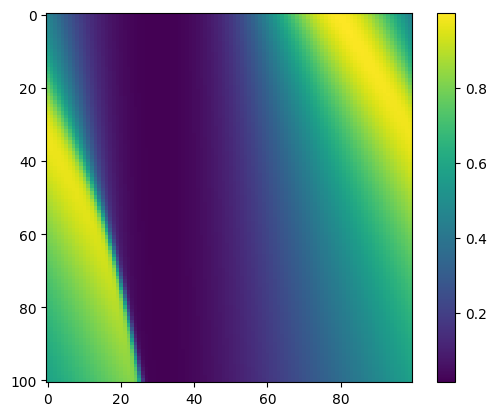

In [146]:
plt.imshow(U[4])
plt.colorbar()





In [147]:

np.random.seed(0)
ntrain = round(0.8 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]



U_train = (U[idx_train]).reshape(-1, nx)
t_train = stacked_time[idx_train]
t_valid = stacked_time[idx_valid]
t_test = stacked_time[idx_test]
U_valid = U[idx_valid].reshape(-1, nx)
U_test = U[idx_test].reshape(-1, nx)

print(np.shape(stacked_time))
print(np.shape(U[idx_train]), np.shape(t_train))
print(np.shape(U[idx_valid]), np.shape(t_valid))
print(np.shape(U[idx_test]), np.shape(t_test))


(50, 101)
(40, 101, 100) (40, 101)
(5, 101, 100) (5, 101)
(5, 101, 100) (5, 101)


[2.53866073 3.17332591 3.8079911 ]
train reconstruction: 5.63%
validation reconstruction: 5.28%
test reconstruction: 5.66%


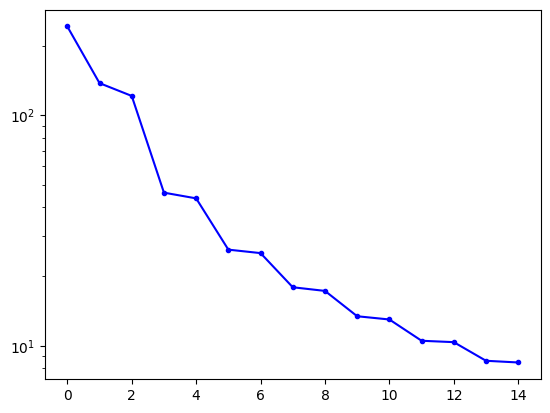

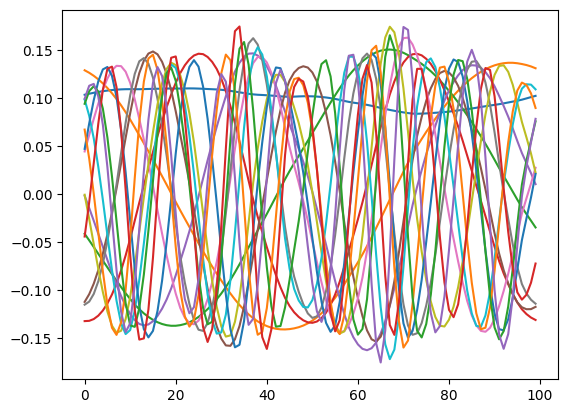

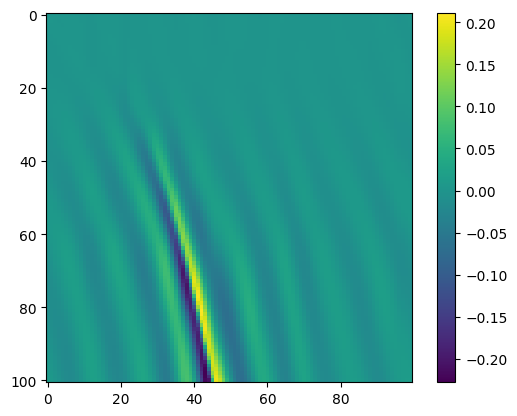

In [148]:
from sklearn.utils.extmath import randomized_svd
from utils.processdata import mre, num2p # Error metrics and format


npixels = 3
pixels_coordinates = [int(2/5 * nx), int(1/2 * nx), int(3/5 * nx)]
print(x[pixels_coordinates])

k = 15 # Number of POD modes


Y, S, V = randomized_svd(U_train, n_components = k)
U_train_pod = (U_train @ V.T)
U_valid_pod = (U_valid @ V.T)
U_test_pod = (U_test @ V.T)

# SCALING

from sklearn.preprocessing import MinMaxScaler

scalerU = MinMaxScaler()
scalerU = scalerU.fit(U_train_pod)
U_train_pod = scalerU.transform(U_train_pod).reshape(-1, nt+1, k)
U_valid_pod = scalerU.transform(U_valid_pod).reshape(-1, nt+1, k)
U_test_pod = scalerU.transform(U_test_pod).reshape(-1, nt+1,k)

U_sensor = np.array(U[:, :,pixels_coordinates])

plt.plot(S, 'b.-')
plt.yscale('log')
plt.figure()
plt.plot(V.T)
plt.figure()
plt.imshow(((U_valid @ V.T) @ V - U_valid).reshape(-1, nt+1,nx)[1])
plt.colorbar()
print('train reconstruction: ' + num2p(mre(torch.from_numpy(U_train), torch.from_numpy((U_train @ V.T) @ V))))
print('validation reconstruction: ' + num2p(mre(torch.from_numpy(U_valid), torch.from_numpy((U_valid @ V.T) @ V))))
print('test reconstruction: ' + num2p(mre(torch.from_numpy(U_test), torch.from_numpy((U_test @ V.T) @ V))))


In [149]:
from utils.processdata import Padding, TimeSeriesDataset

device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 100

train_data_in = Padding(torch.from_numpy(U_sensor[idx_train]), lag).to(device)
valid_data_in = Padding(torch.from_numpy(U_sensor[idx_valid]), lag).to(device)
test_data_in = Padding(torch.from_numpy(U_sensor[idx_test]), lag).to(device)


train_data_out = Padding(torch.from_numpy(U_train_pod), 1).squeeze(1).to(device)
valid_data_out = Padding(torch.from_numpy(U_valid_pod), 1).squeeze(1).to(device)
test_data_out = Padding(torch.from_numpy(U_test_pod), 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [150]:
print(np.shape(train_dataset.X))
print(np.shape(train_dataset.Y))

print(np.shape(valid_dataset.X))
print(np.shape(valid_dataset.Y))


print(np.shape(test_dataset.X))
print(np.shape(test_dataset.Y))

torch.Size([4040, 100, 3])
torch.Size([4040, 15])
torch.Size([505, 100, 3])
torch.Size([505, 15])
torch.Size([505, 100, 3])
torch.Size([505, 15])


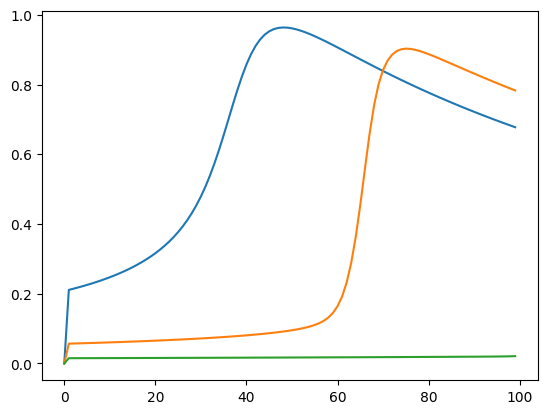

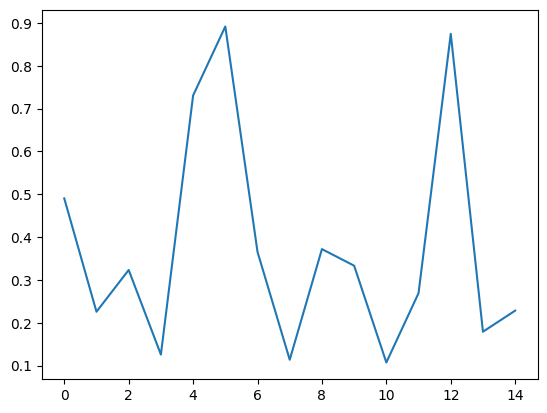

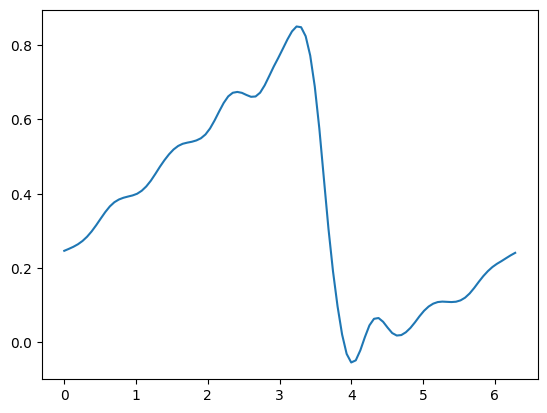

In [151]:
idx = 300

plt.plot(train_dataset.X[idx])

plt.figure()
plt.plot(train_dataset.Y[idx])
plt.figure()
plt.plot(x, scalerU.inverse_transform(train_dataset.Y)[idx] @ V  )



In [ ]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(npixels, k, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 100, lr = 1e-3, verbose = True, patience = 100, step_size = 100)

Training done: Training loss = 4.75% 	 Validation loss = 4.59%       	 learning rate = 0.0001


In [ ]:
from utils.processdata import mre, num2p # Error metrics and format

y_hat = shred.forward(test_dataset.X)
y_test = test_dataset.Y
print(mre(y_test, y_hat  ), num2p(mre(y_test , y_hat )))

tensor(0.0695, grad_fn=<MeanBackward0>) 6.95%


In [ ]:

y_hat = scalerU.inverse_transform(torch.detach(shred.forward(test_dataset.X)).numpy()) @ V 
y_test = torch.from_numpy(U_test)
print(mre(y_test, torch.from_numpy(y_hat)), num2p(mre(y_test , torch.from_numpy(y_hat) )))

tensor(0.0777, dtype=torch.float64) 7.77%


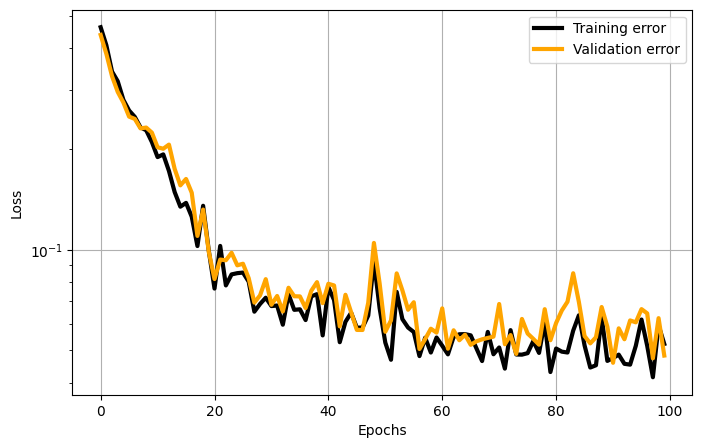

In [ ]:
# TRAINING HISTORY VISUALIZATION

plt.figure(figsize = (8,5))
plt.plot(train_errors, 'k', linewidth = 3, label = 'Training error')
plt.plot(valid_errors, 'orange', linewidth = 3, label = 'Validation error')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

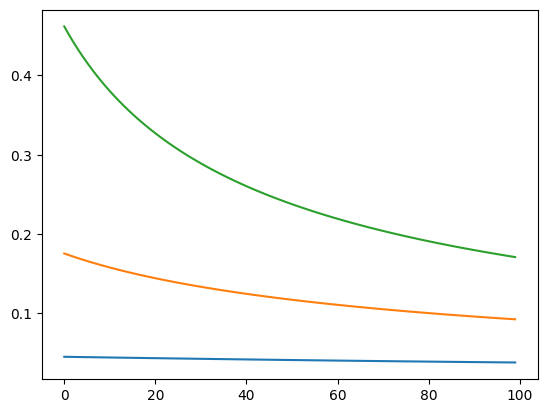

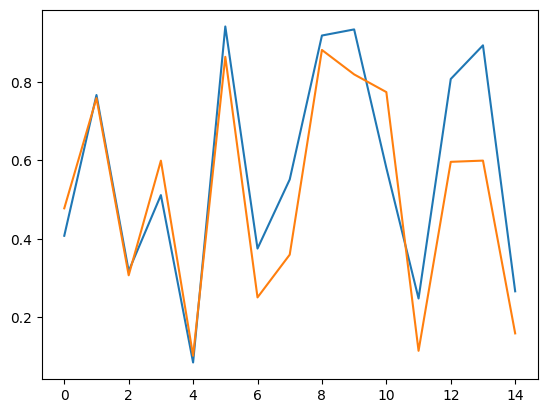

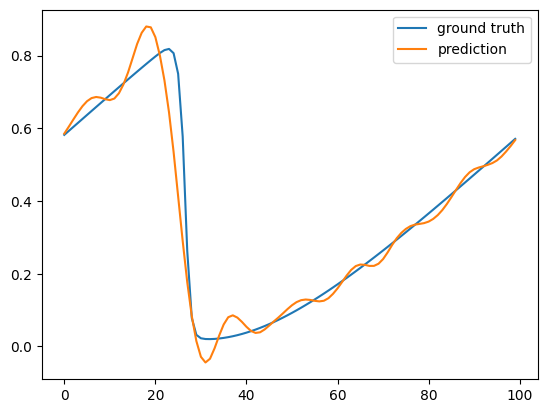

In [ ]:
idx = 100
plt.plot(test_dataset.X[idx])

plt.figure()
plt.plot(torch.detach(shred.forward(test_data_in)).numpy()[idx] , label = 'offline prediction ')
plt.plot(torch.detach(test_data_out).numpy()[idx] , label = 'offline test ' )
plt.figure()
plt.plot(U_test[idx], label = 'ground truth')
plt.plot(y_hat[idx], label = 'prediction' )
plt.legend()

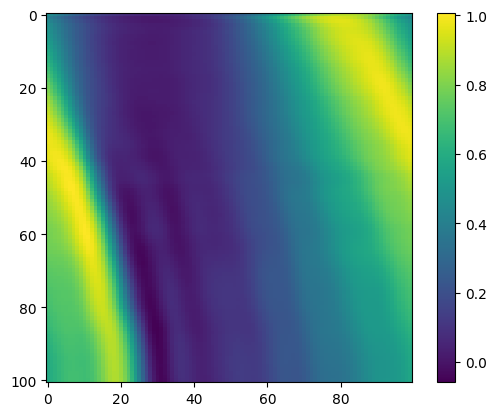

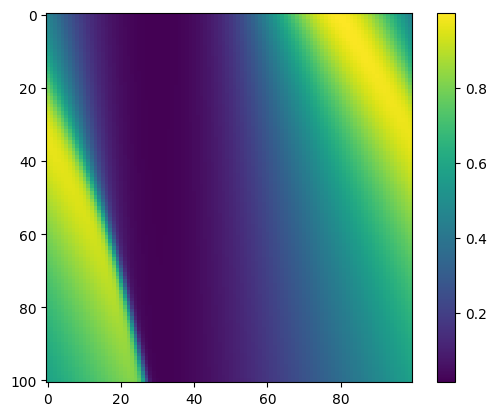

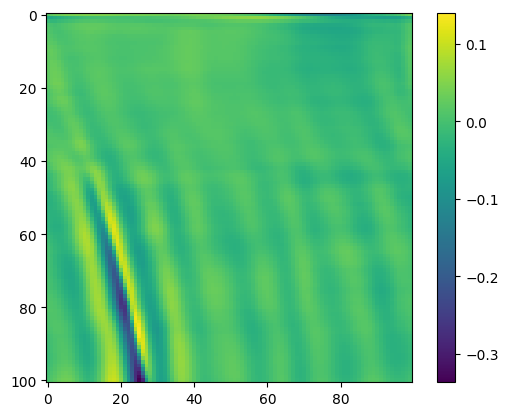

In [ ]:
idx = 0
plt.imshow(y_hat.reshape(-1, nt + 1, nx)[idx])
plt.colorbar()
plt.figure()
plt.imshow(U_test.reshape(-1, nt +1, nx)[idx] )
plt.colorbar()
plt.figure()
plt.imshow(y_hat.reshape(-1, nt + 1, nx)[idx] - U_test.reshape(-1, nt +1, nx)[idx] )
plt.colorbar()

In [299]:
from torch.utils.data import Dataset, DataLoader
import torch

class BranchTrunkDataset(Dataset):
    """
    PyTorch Dataset for DeepONet or branch/trunk networks.
    
    Each item is ((trunk_input, branch_input), target)
    """
    def __init__(self, trunk_data, branch_data, targets):
        """
        trunk_data: torch.Tensor of shape (N, trunk_features)
        branch_data: torch.Tensor of shape (N, branch_features)
        targets: torch.Tensor of shape (N, output_features)
        """
        assert len(trunk_data) == len(branch_data) == len(targets), \
            "Trunk, branch, and targets must have the same number of samples."
        
        self.trunk_data = trunk_data
        self.branch_data = branch_data
        self.Y = targets

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        trunk_input = self.trunk_data[idx]
        branch_input = self.branch_data[idx]
        target = self.Y[idx]
        
        return (trunk_input, branch_input), target

In [300]:
device = 'cpu'
lag = 100
# Trunk input: sequences of sensors
data_in = Padding(torch.from_numpy(U_sensor).float(), lag).to(device)

print(np.shape(data_in))


train_branch = Padding(torch.from_numpy(U_sensor[idx_train]), lag).to(device)
valid_branch = Padding(torch.from_numpy(U_sensor[idx_valid]), lag).to(device)
test_branch = Padding(torch.from_numpy(U_sensor[idx_test]), lag).to(device)

# Branch input: e.g., stacked time
train_trunk = torch.tensor(t_train, dtype=torch.float32).view(-1, 1).to(device)  # (num_samples, 1)
valid_trunk = torch.tensor(t_valid, dtype=torch.float32).view(-1, 1).to(device)
test_trunk = torch.tensor(t_test, dtype=torch.float32).view(-1, 1).to(device)

train_data_out = Padding(torch.from_numpy(U_train_pod), 1).squeeze(1).to(device)
valid_data_out = Padding(torch.from_numpy(U_valid_pod), 1).squeeze(1).to(device)
test_data_out = Padding(torch.from_numpy(U_test_pod), 1).squeeze(1).to(device)

torch.Size([5050, 100, 3])


In [301]:
print(np.shape(train_branch), np.shape(valid_branch))
print(np.shape(train_trunk), np.shape(valid_trunk))

torch.Size([4040, 100, 3]) torch.Size([505, 100, 3])
torch.Size([4040, 1]) torch.Size([505, 1])


In [325]:
# DEFINE lstm deepOnet MODEL

class lstm_deepONet(torch.nn.Module):

    def __init__(self, input_size , output_size, hidden_size = 64, hidden_layers = {'branch':2, 'trunk':2}, dropout = 0.1, basis_functions = 10):
        '''
        Deeponet arcitecture for time series data. 
        In branch net is a lstm network
        Trunk netwrok is a simple feedforward network 
        Inputs
            input size  for branch and trunk                    (`dict`)
        	output size (e.g. full-order variable dimension)    (`int`)
        	size hidden layers                          (`int`)
        	number of hidden layers                        (`int`)
        	list of decoder layers sizes                        (`list[int]`)
        	dropout parameter                                   (`float`)
        '''

        super(lstm_deepONet,self).__init__()

        self.branch_lstm = torch.nn.LSTM(input_size = input_size['branch'],
                                  hidden_size = hidden_size,
                                  num_layers = hidden_layers['branch'],
                                  batch_first=True)
        self.branch_encoder = torch.nn.Linear(hidden_size, basis_functions * output_size)
        
        layers = []
            
        layers.append(torch.nn.Linear(input_size['trunk'], hidden_size))
        layers.append(torch.nn.ReLU())
        
        for _ in range(hidden_layers['trunk'] - 1):
            layers.append(torch.nn.Linear(hidden_size, hidden_size))
            layers.append(torch.nn.ReLU())
        
        layers.append(torch.nn.Linear(hidden_size, basis_functions * output_size) )
        
        self.trunk = torch.nn.Sequential(*layers)
        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.basis_functions = basis_functions
        
    def forward(self, trunk_input, branch_input):
        batch_size = branch_input.size(0)
        device = branch_input.device

        h_0 = torch.zeros(self.hidden_layers['branch'], batch_size, self.hidden_size, device=device)
        c_0 = torch.zeros(self.hidden_layers['branch'], batch_size, self.hidden_size, device=device)

        _, (output_branch, _) = self.branch_lstm(branch_input, (h_0, c_0))
        output_branch = self.branch_encoder(output_branch[-1])  # last layer's hidden state
        output_branch = output_branch.view(-1, self.basis_functions, self.output_size)

        trunk_input = trunk_input.view(batch_size, -1)
        output_trunk = self.trunk(trunk_input)
        output_trunk = output_trunk.view(-1, self.basis_functions, self.output_size)

        out = torch.sum(output_trunk * output_branch, dim=1)
        return out


    def freeze(self):

        self.eval()

        for param in self.parameters():
            param.requires_grad = False

    def unfreeze(self):

        self.train()

        for param in self.parameters():
            param.requires_grad = True


In [326]:
# DEFINE TRAINING FUNCTION
from torch.utils.data import DataLoader
from copy import deepcopy
from IPython.display import clear_output as clc
from torch.optim.lr_scheduler import StepLR
from utils.processdata import mse, mre, num2p

mse = lambda datatrue, datapred: (datatrue - datapred).pow(2).sum(axis = -1).mean()  # Mean Squared Error



def fit_deepONet(model, train_dataset, valid_dataset=None, batch_size=64, epochs=50,
        optim=torch.optim.Adam, lr=1e-3, loss_fun=mre, loss_output=mre,
         verbose=False, patience=5, device='cpu'):

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    optimizer = optim(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
    
    train_error_list = []
    valid_error_list = []
    patience_counter = 0
    best_params = deepcopy(model.state_dict())

    model.to(device)

    for epoch in range(1, epochs + 1):

        model.train()
        for batch in train_loader:
            # unpack branch, trunk, and target
            (trunk_input, branch_input), y = batch  
            trunk_input = trunk_input.to(device)
            branch_input = branch_input.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            outputs = model(trunk_input, branch_input)
            # print(np.shape(outputs), np.shape(y))
            loss = loss_fun(outputs, y)
            loss.backward()
            optimizer.step()

        # evaluation
        model.eval()
        scheduler.step()

        with torch.no_grad():
            if valid_dataset is not None:
                train_error = loss_output(train_dataset.Y.to(device), model(train_dataset.trunk_data, train_dataset.branch_data))
                valid_error = loss_output(valid_dataset.Y.to(device), model(valid_dataset.trunk_data, valid_dataset.branch_data))
            else:
                train_error = loss_output(train_dataset.Y.to(device), model(train_dataset.trunk_data, train_dataset.branch_data))
                valid_error = train_error

            train_error_list.append(train_error.item())
            valid_error_list.append(valid_error.item())

        # verbose
        if verbose:
            print(f"Epoch {epoch}: Train Loss = {train_error}, Valid Loss = {valid_error}, learning rate = {scheduler.get_last_lr()[0]}")

        # early stopping
        if valid_error == min(valid_error_list):
            patience_counter = 0
            best_params = deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter >= patience:
            model.load_state_dict(best_params)
            if verbose:
                print("Early stopping triggered")
            break

    model.load_state_dict(best_params)
    return train_error_list, valid_error_list


In [327]:
np.shape(train_branch), np.shape(train_trunk)

(torch.Size([4040, 100, 3]), torch.Size([4040, 1]))

In [328]:
train_dataset_don = BranchTrunkDataset(train_trunk, train_branch, train_data_out)
valid_dataset_don = BranchTrunkDataset(valid_trunk, valid_branch, valid_data_out)
test_dataset_don = BranchTrunkDataset(test_trunk, test_branch, test_data_out)

tensor([0.4000])


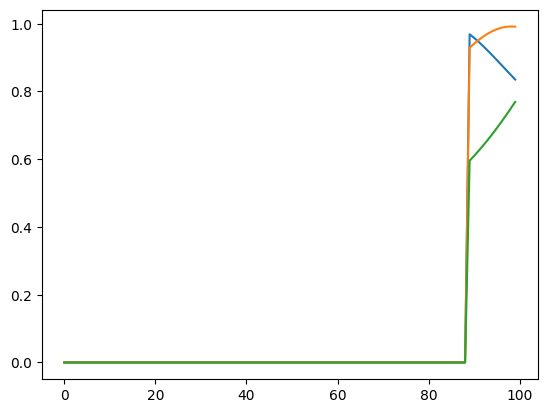

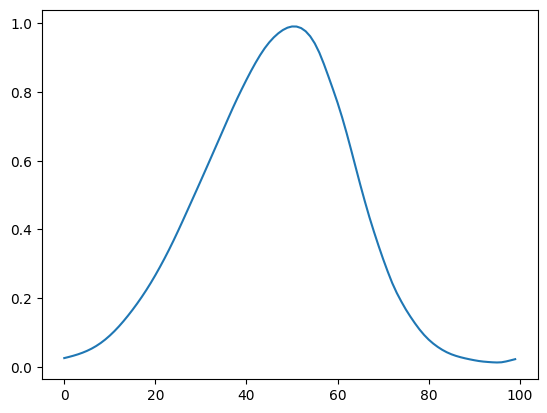

In [329]:
idx = 10
print(train_dataset_don.trunk_data[idx])
plt.plot(train_dataset_don.branch_data[idx])
plt.figure()
plt.plot(scalerU.inverse_transform(train_dataset_don.Y)[idx]@V)

In [330]:
lstm_DON = lstm_deepONet(input_size={'branch':3, 'trunk':1}, output_size=1, hidden_size = 64, hidden_layers= {'branch':1, 'trunk':2}, dropout = 0.1)


In [331]:
print(np.shape(test_dataset_don.Y))
print(np.shape(test_dataset_don.trunk_data))
print(np.shape(test_dataset_don.branch_data))


torch.Size([505, 15])
torch.Size([505, 1])
torch.Size([505, 100, 3])


In [332]:
y_hat = lstm_DON.forward(test_dataset_don.trunk_data, test_dataset_don.branch_data)
np.shape(y_hat)

torch.Size([505, 1])

In [ ]:
lstm_DON = lstm_deepONet(input_size={'branch':3, 'trunk':1}, output_size=k, hidden_size = 64, hidden_layers= {'branch':3, 'trunk':4}, dropout = 0.1)
train_errors_DON, valid_errors_DON = fit_deepONet(lstm_DON, train_dataset_don, valid_dataset_don, verbose = True, lr = 1e-3, epochs = 100, patience = 10)

Epoch 1: Train Loss = 11.655924797058105, Valid Loss = 11.068643569946289, learning rate = 0.001
Epoch 2: Train Loss = 0.881231963634491, Valid Loss = 0.7821594476699829, learning rate = 0.001
Epoch 3: Train Loss = 0.5393257141113281, Valid Loss = 0.4949409067630768, learning rate = 0.001
Epoch 4: Train Loss = 0.5016274452209473, Valid Loss = 0.4662662148475647, learning rate = 0.001
Epoch 5: Train Loss = 0.47528091073036194, Valid Loss = 0.4267561733722687, learning rate = 0.001
Epoch 6: Train Loss = 0.4075101912021637, Valid Loss = 0.37334227561950684, learning rate = 0.001
Epoch 7: Train Loss = 0.36034920811653137, Valid Loss = 0.34008553624153137, learning rate = 0.001
Epoch 8: Train Loss = 0.29099225997924805, Valid Loss = 0.2979067265987396, learning rate = 0.001
Epoch 9: Train Loss = 0.2564515769481659, Valid Loss = 0.2873761057853699, learning rate = 0.001
Epoch 10: Train Loss = 0.1966887265443802, Valid Loss = 0.22277067601680756, learning rate = 0.001
Epoch 11: Train Loss = 0

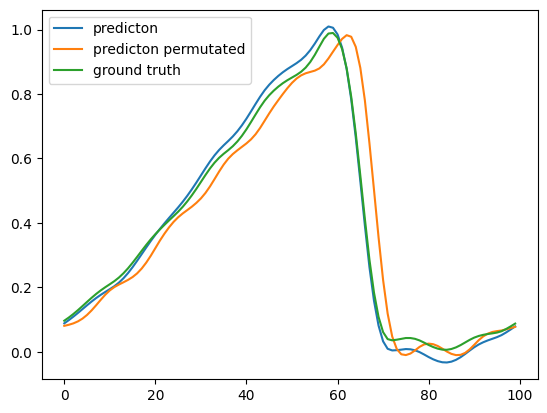

In [397]:
idx = 250
idx_permutation = idx + 10
test_trunk = torch.tensor(np.roll(t_test,10), dtype=torch.float32).view(-1, 1).to(device)
test_dataset_don_tilde = BranchTrunkDataset(test_trunk, test_branch, test_data_out )

y_hat = lstm_DON.forward(test_dataset_don.trunk_data, test_dataset_don.branch_data)
y_tilde = lstm_DON.forward(test_dataset_don_tilde.trunk_data, test_dataset_don_tilde.branch_data)

plt.plot(scalerU.inverse_transform(torch.detach(y_hat).numpy())[idx] @ V, label = 'predicton')
plt.plot(scalerU.inverse_transform(torch.detach(y_tilde).numpy())[idx_permutation] @ V, label = 'predicton permutated')
plt.plot(scalerU.inverse_transform(torch.detach(test_dataset_don.Y).numpy())[idx] @ V, label = 'ground truth')
plt.legend()